# PREPROCESS MERFISH

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import torch
import torchvision.transforms as transforms
import numpy
import skimage.filters
import skimage.exposure
import skimage.transform
import skimage.morphology
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None
from MODULES.namedtuple import ImageBbox, PreProcess
from MODULES.utilities import save_obj, load_obj, load_json_as_dict

### Helper function

In [4]:
def img_pre_processing(pilfile, reduction_factor=1, remove_background=True):
    """ Resize and rescale intensities in (0,1) """
    
    # Open and resize using bilinear interpolation
    w_raw, h_raw = pilfile.size
    w_new = int(w_raw/reduction_factor)
    h_new = int(h_raw/reduction_factor)
    pilresize = pilfile.convert("F").resize((w_new, h_new), resample=PIL.Image.BILINEAR)
    img_np = numpy.array(pilresize)
    
    # Compute NUCLEI and ROI masks
    image_thresh = skimage.filters.threshold_otsu(img_np)
    NUCLEI_mask = (img_np > image_thresh)
    #ROI_mask = skimage.morphology.convex_hull_image(NUCLEI_mask) * (img_np > 1E-5)
    ROI_mask = (img_np > 1E-5)
        
    # Rescale foreground intensity in (0,1)
    if remove_background:
        ql, qr = numpy.percentile(img_np[img_np > image_thresh].flatten(), q=(0, 100))  # note that the statistics are compute on the foreground only
        img_tmp = skimage.exposure.rescale_intensity(img_np, in_range=(ql, qr), out_range=(0.0, 1.0))
    else:
        img_tmp = skimage.exposure.rescale_intensity(img_np, in_range="image", out_range=(0.0, 1.0))
        
    return img_tmp, NUCLEI_mask, ROI_mask


def find_bbox(mask):
    assert len(mask.shape) == 2
    row = numpy.sum(mask, axis=-1) > 0
    col = numpy.sum(mask, axis=-2) > 0
    max_row = max(numpy.arange(row.shape[0]) * row) + 1
    min_row = row.shape[0] - max(numpy.arange(start=row.shape[0], stop=0, step=-1) * row)
    max_col = max(numpy.arange(col.shape[0]) * col) + 1
    min_col = col.shape[0] - max(numpy.arange(start=col.shape[0], stop=0, step=-1) * col)
    return ImageBbox(min_row=min_row,
                     min_col=min_col,
                     max_row=max_row,
                     max_col=max_col)


def show_random_examples(img: numpy.ndarray,
                         nexamples: int = 9, 
                         ncols: int = 3, 
                         crop_size: int = 200,
                         figsize: tuple = (12,12)):
    
    nrows=int(numpy.ceil(nexamples/ncols))
    iw_array = numpy.random.randint(low=0, high=img.shape[-2]-crop_size, size=nexamples, dtype=int)
    ih_array = numpy.random.randint(low=0, high=img.shape[-1]-crop_size, size=nexamples, dtype=int)

    if nrows == 1:
        figure, axes = plt.subplots(ncols=ncols, figsize=figsize)
        for n in range(nexamples):
            axes[n].imshow(img[iw_array[n]:iw_array[n]+crop_size,
                               ih_array[n]:ih_array[n]+crop_size], cmap='gray')
    else:
        figure, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        for n in range(nexamples):
            r = int(n / ncols)
            c = numpy.mod(n,ncols)
            axes[r,c].imshow(img[iw_array[n]:iw_array[n]+crop_size,
                                 ih_array[n]:ih_array[n]+crop_size], cmap='gray')

### The entire preprocessing is here

In [44]:
input_file = "DAPI_Overview.tif"
reduction_factor=1
pilfile = PIL.Image.open(input_file)
print("size raw image ->", pilfile.size)

img_tmp, NUCLEI_mask, ROI_mask = img_pre_processing(pilfile, reduction_factor=reduction_factor, remove_background=False)
img = img_tmp
#img = skimage.exposure.equalize_adapthist(img_tmp, kernel_size=160, clip_limit=0.03)

size raw image -> (19558, 21504)


### Visualize

Text(0.5, 1.0, 'ROI mask')

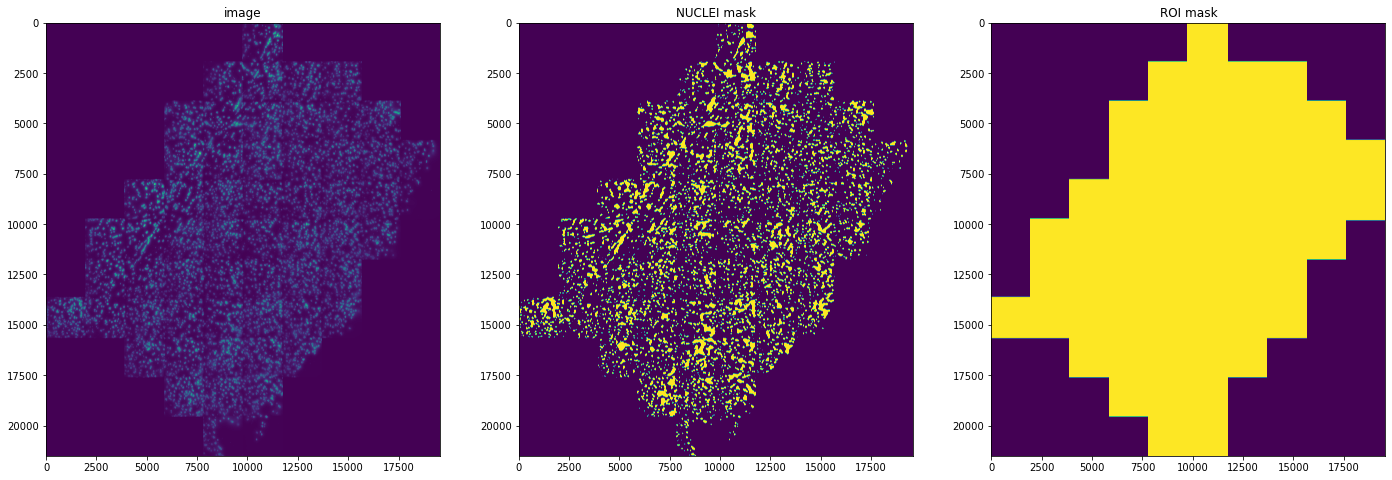

In [45]:
fig, axs = plt.subplots(ncols=3, figsize=(24,24))
axs[0].imshow(img)
axs[1].imshow(NUCLEI_mask)
axs[2].imshow(ROI_mask)
axs[0].set_title("image")
axs[1].set_title("NUCLEI mask")
axs[2].set_title("ROI mask")

Text(0.5, 1.0, 'ROI mask')

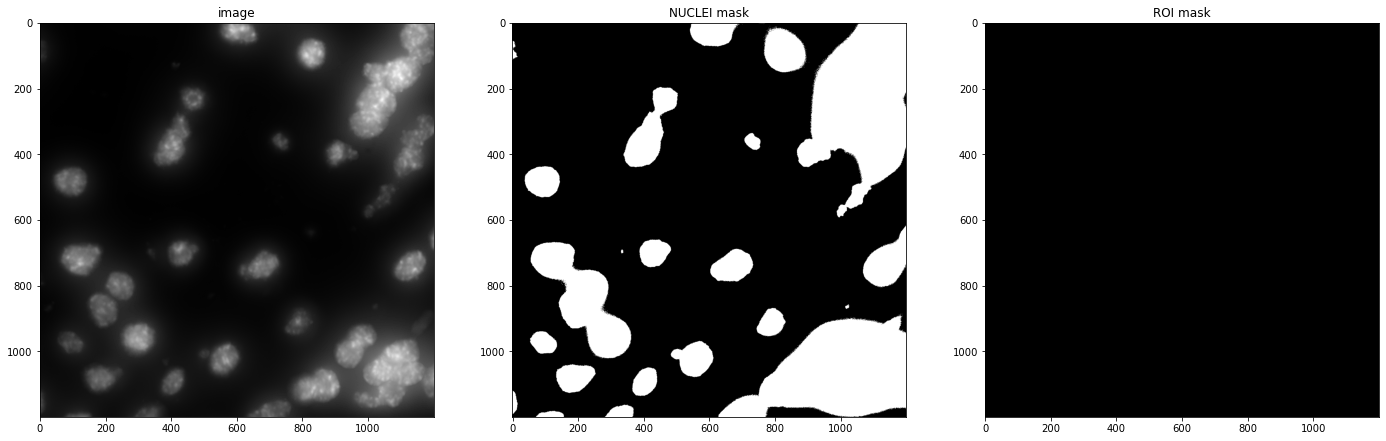

In [48]:
window = (1000,2100,1300,2400)
window = (4*1000,4*2100,4*1300,4*2400)
fig, axs = plt.subplots(ncols=3, figsize=(24,24))
axs[0].imshow(img[window[0]:window[2],window[1]:window[3]], cmap='gray')
axs[1].imshow(NUCLEI_mask[window[0]:window[2],window[1]:window[3]], cmap='gray')
axs[2].imshow(ROI_mask[window[0]:window[2],window[1]:window[3]], cmap='gray')
axs[0].set_title("image")
axs[1].set_title("NUCLEI mask")
axs[2].set_title("ROI mask")

### Crop the image to the smallest rectangle which fits the ROI_mask

In [49]:
bbox_original= ImageBbox(min_row=0,
                         min_col=0,
                         max_row=img.shape[0],
                         max_col=img.shape[1])

#bbox_crop = find_bbox(ROI_mask)
bbox_crop = bbox_original
print(bbox_original)
print(bbox_crop)

crop_img = img[bbox_crop.min_row:bbox_crop.max_row,
               bbox_crop.min_col:bbox_crop.max_col]
crop_ROI_mask = ROI_mask[bbox_crop.min_row:bbox_crop.max_row,
                         bbox_crop.min_col:bbox_crop.max_col]

ImageBbox(min_row=0, min_col=0, max_row=21504, max_col=19558)
ImageBbox(min_row=0, min_col=0, max_row=21504, max_col=19558)


In [50]:
tmp=PreProcess(img=transforms.ToTensor()(crop_img)[None],
               roi_mask=transforms.ToTensor()(crop_ROI_mask)[None],
               bbox_original=bbox_original,
               bbox_crop=bbox_crop)
print(tmp.img.shape)
print(tmp.roi_mask.shape)
assert len(tmp.img.shape) == len(tmp.roi_mask.shape) == 4

torch.Size([1, 1, 21504, 19558])
torch.Size([1, 1, 21504, 19558])


### Show random example before saving

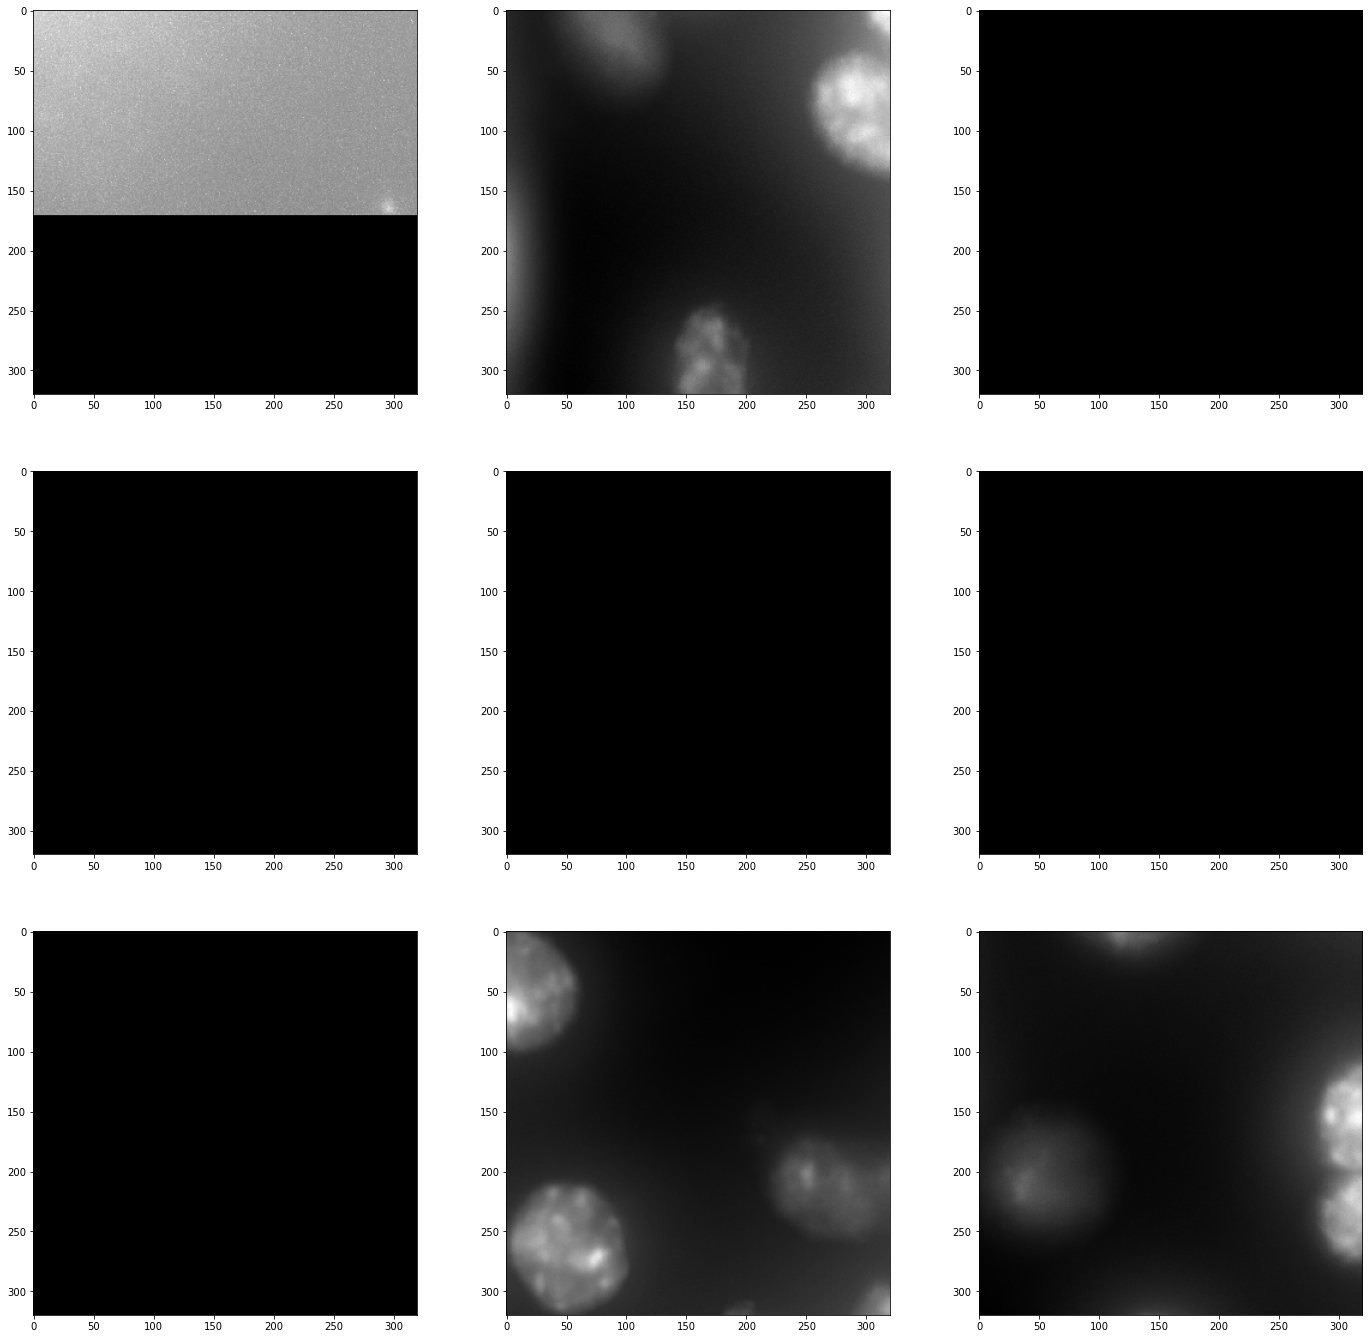

In [53]:
show_random_examples(img=tmp.img[0,0].cpu(),
                     nexamples=9, 
                     ncols=3, 
                     crop_size=4*80,
                     figsize=(24,24))

In [54]:
base_name = os.path.basename(input_file)
f = "streamlined_"+str(reduction_factor)+"_"+base_name

save_obj(tmp, f)
print(f)

streamlined_1_DAPI_Overview.tif


In [ ]:
# Check that I can load
a = load_obj(f)